In [1]:
# import modules
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, LeakyReLU, Input, BatchNormalization, Softmax, Reshape, Conv2DTranspose, Activation
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt


In [2]:
# Load the dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
# combine test and train data. 
images_real = np.vstack((train_images, test_images))
labels_real = np.concatenate((train_labels, test_labels))

In [4]:
num_real_data_items = images_real.shape[0]

In [5]:
# activation_funcion = Activation("tanh")
# activation_funcion = Activation("sigmoid")
activation_funcion = LeakyReLU(alpha=0.2)
use_normalisation = True
use_dropout = True

In [6]:
# create discriminator model similar to perceptron
model_discriminator = Sequential()

model_discriminator.add(Input((28, 28, 1)))
if use_normalisation: model_discriminator.add(BatchNormalization())

# model_discriminator.add(Conv2D(10, kernel_size=(5, 5)))
# model_discriminator.add(activation_funcion)
# if use_dropout: model_discriminator.add(Dropout(0.2))

model_discriminator.add(Flatten())

for _ in range(2):
    model_discriminator.add(Dense(20))
    model_discriminator.add(activation_funcion)
    if use_dropout: model_discriminator.add(Dropout(0.2))


model_discriminator.add(Dense(1))
model_discriminator.add(Activation("sigmoid"))
# model_discriminator.add(Softmax())

# model_discriminator.add(Activation("tanh"))


In [7]:
model_discriminator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 28, 28, 1)         4         
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 20)                15700     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 20)                0         
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                        

In [8]:
model_discriminator.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [9]:
# create model generator
model_generator = Sequential()

model_generator.add(Input(110))

model_generator.add(Dense(16**2))   
model_generator.add(activation_funcion)
if use_dropout: model_generator.add(Dropout(0.2))


model_generator.add(Dense(16**2))   
model_generator.add(activation_funcion)
if use_dropout: model_generator.add(Dropout(0.2))

model_generator.add(Reshape((16, 16, 1)))

# map 16*16 to 22*22
model_generator.add(Conv2DTranspose(1, (7, 7), (1, 1)))
model_generator.add(activation_funcion)
if use_dropout: model_generator.add(Dropout(0.2))


# map 22*22 to 28*28
model_generator.add(Conv2DTranspose(1, (7, 7), (1, 1)))
model_generator.add(Activation("sigmoid"))


In [10]:
model_generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               28416     
                                                                 
 leaky_re_lu (LeakyReLU)     multiple                  0         
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 1)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 22, 22, 1)        

In [11]:
generator_input = Input(110)
generator_output = model_generator(generator_input)
discriminator_output = model_discriminator(generator_output)

GAN_combined_model = Model(inputs=generator_input, outputs=discriminator_output)

GAN_combined_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
def create_chunk_of_generator_inputs(chunk_size):
    # Generate a random noise vector
    random_seed_vectors = np.random.randn(100*chunk_size).reshape(chunk_size, 100)

    # Generate a random one-hot encoded label
    random_labels = np.random.randint(0, 10, chunk_size)
    one_hot_labels = to_categorical(random_labels, num_classes=10)

    # Generate a fake image using the generator, with both noise and label as inputs
    generator_inputs = np.concatenate((random_seed_vectors, one_hot_labels), axis=1)
    return generator_inputs

In [13]:
def generate_real_training_chunks(chunk_size):
    assert 1 <= chunk_size and isinstance(chunk_size, int)

    num_chunks = num_real_data_items // chunk_size

    # make array of indexes corresponding to training data items
    indexes = np.arange(num_real_data_items)
    # shuffle the array
    np.random.shuffle(indexes)
    
    # yield sections of the 
    for chunk_num in range(num_chunks):
        chunk_indexes = indexes[chunk_size*chunk_num: chunk_size*(chunk_num+1)]

        chunk_images = np.array([images_real[index] for index in chunk_indexes])
        chunk_labels = np.array([labels_real[index] for index in chunk_indexes])

        yield (chunk_images, chunk_labels)

In [14]:
def create_fake_training_chunk(chunk_size):
    generator_inputs = create_chunk_of_generator_inputs(chunk_size)
    return model_generator.predict(generator_inputs)


In [15]:
def plot_images_from_generator():
    fig, axes = plt.subplots(10, 10, figsize=(14,14))
    for number_to_plot in range(10):
        for j in range(10):
            random_seed_vector = np.random.randn(100)
            
            one_hot_label = to_categorical(number_to_plot, num_classes=10)


            generator_input = np.concatenate([random_seed_vector, one_hot_label]).reshape(1, 110)
            # print(generator_input.shape)
            generated_image = model_generator.predict(generator_input)

            axes[number_to_plot, j].imshow(
                generated_image.reshape(28, 28),
                cmap="gray"
            )

    plt.show()
    plt.close()

1/1 [==============================] - 0s 31ms/step


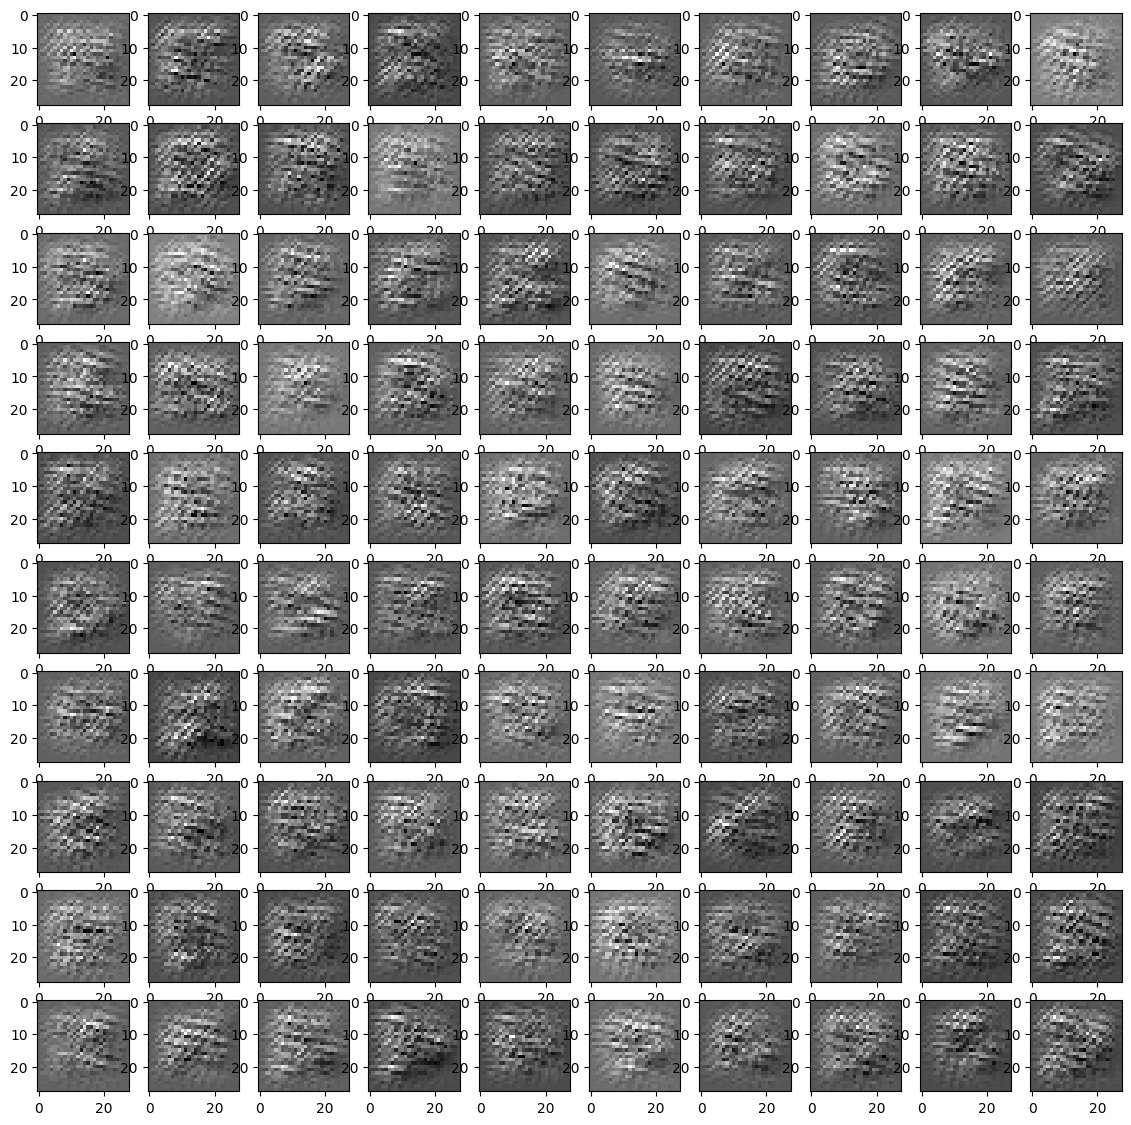

In [16]:
plot_images_from_generator()

In [17]:
for real_images, real_labels in generate_real_training_chunks(20):
    print(model_discriminator.predict(real_images))
    break

fake_images = create_fake_training_chunk(20)
print(model_discriminator.predict(fake_images))

1/1 [==============================] - 0s 111ms/step
[[1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.71049255]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]]
1/1 [==============================] - 0s 88ms/step
[[0.6934747 ]
 [0.69806796]
 [0.69433326]
 [0.6977503 ]
 [0.6921851 ]
 [0.6948705 ]
 [0.70138997]
 [0.68549234]
 [0.69232696]
 [0.6952244 ]
 [0.6906701 ]
 [0.69375783]
 [0.68550515]
 [0.69589776]
 [0.68620926]
 [0.7005022 ]
 [0.68905115]
 [0.69372505]
 [0.69500196]
 [0.6822523 ]]


In [18]:
np.full((20,), 1.0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [19]:
np.full((20,), 0.0),

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),)

In [20]:
real_batch_size = 50
num_batches = num_real_data_items // real_batch_size
num_batches_before_alternating = 10
epochs = 1

In [21]:
def plot_25_images(images):
    fig, axes = plt.subplots(5, 5, figsize=(14,14))
    for i in range(5):
        for j in range(5):
            axes[i, j].imshow(
                images[5*i+j].reshape(28, 28),
                cmap="gray"
            )

    plt.show()
    plt.close()

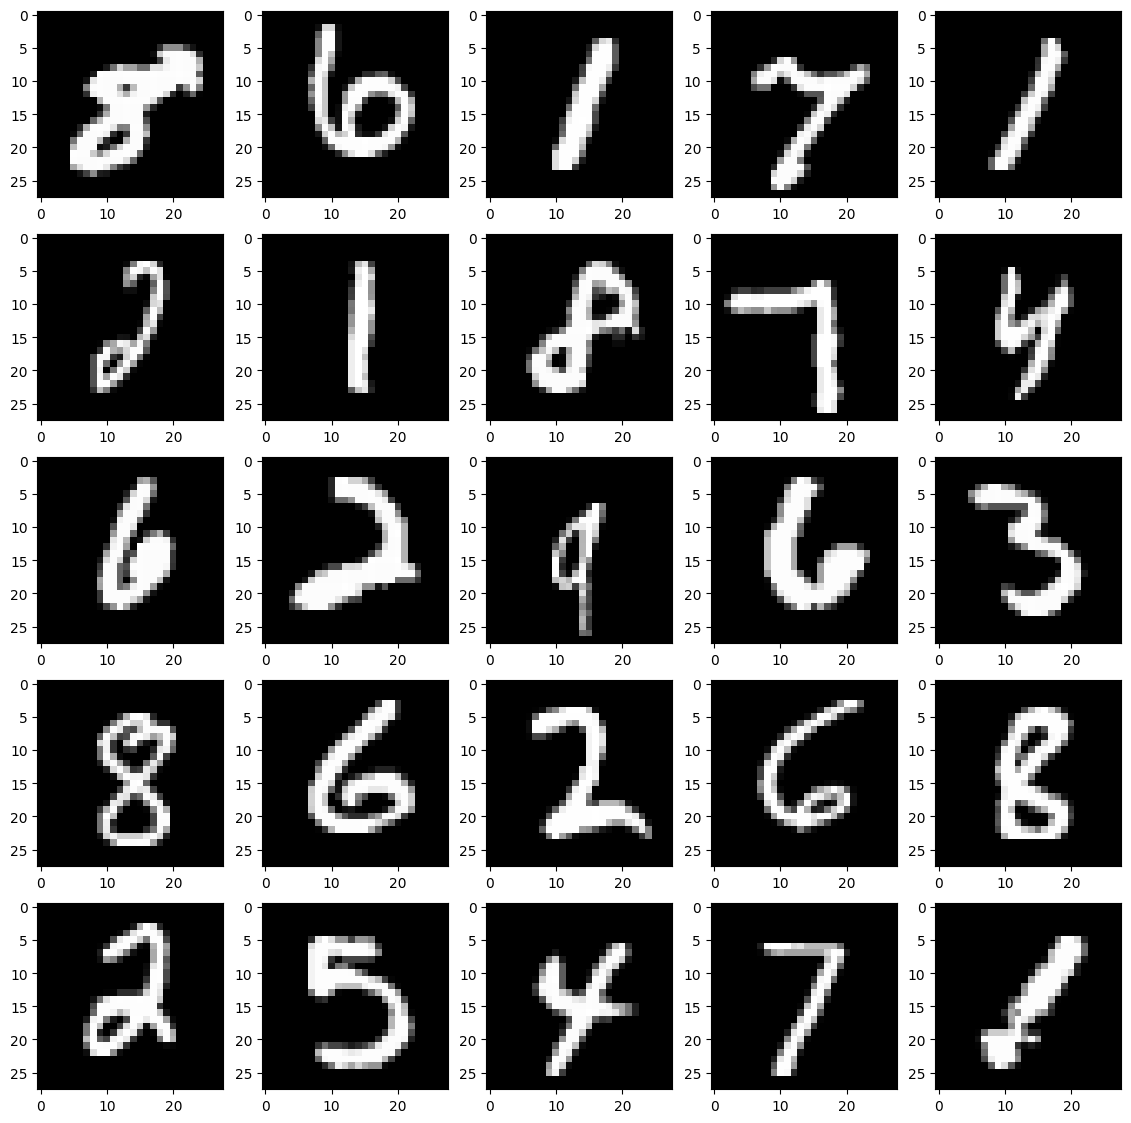

In [22]:
for real_images, real_labels in generate_real_training_chunks(25):
    plot_25_images(real_images)
    break

1/1 [==============================] - 0s 31ms/step


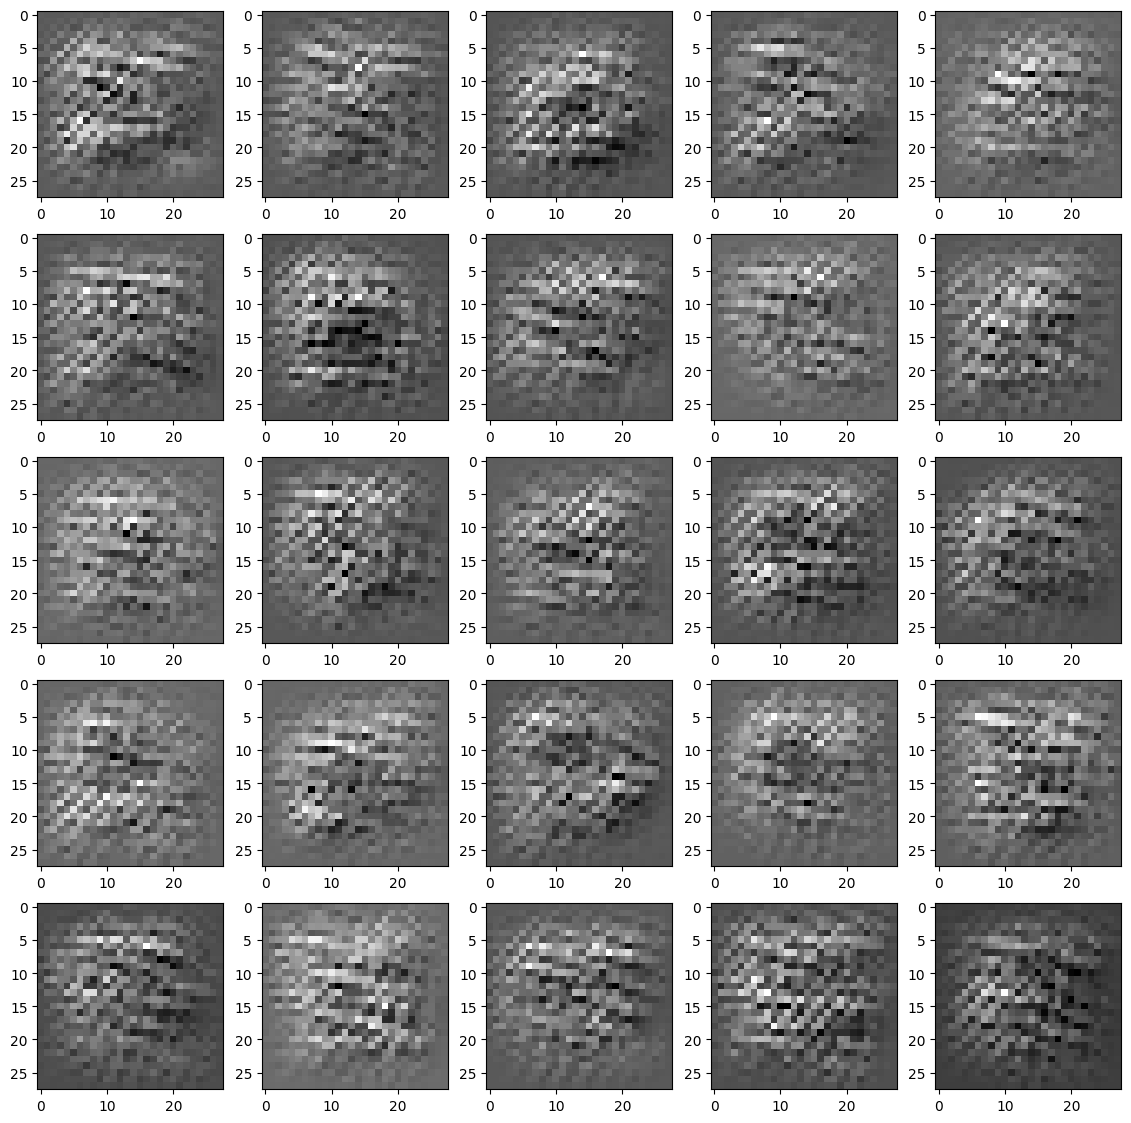

In [23]:
plot_25_images(create_fake_training_chunk(25))

In [24]:
real_image_chunks = []
for chunk_real_images, chunk_real_labels in generate_real_training_chunks(200):
    real_image_chunks.append(chunk_real_images)
    if len(real_image_chunks) == 1:
        break

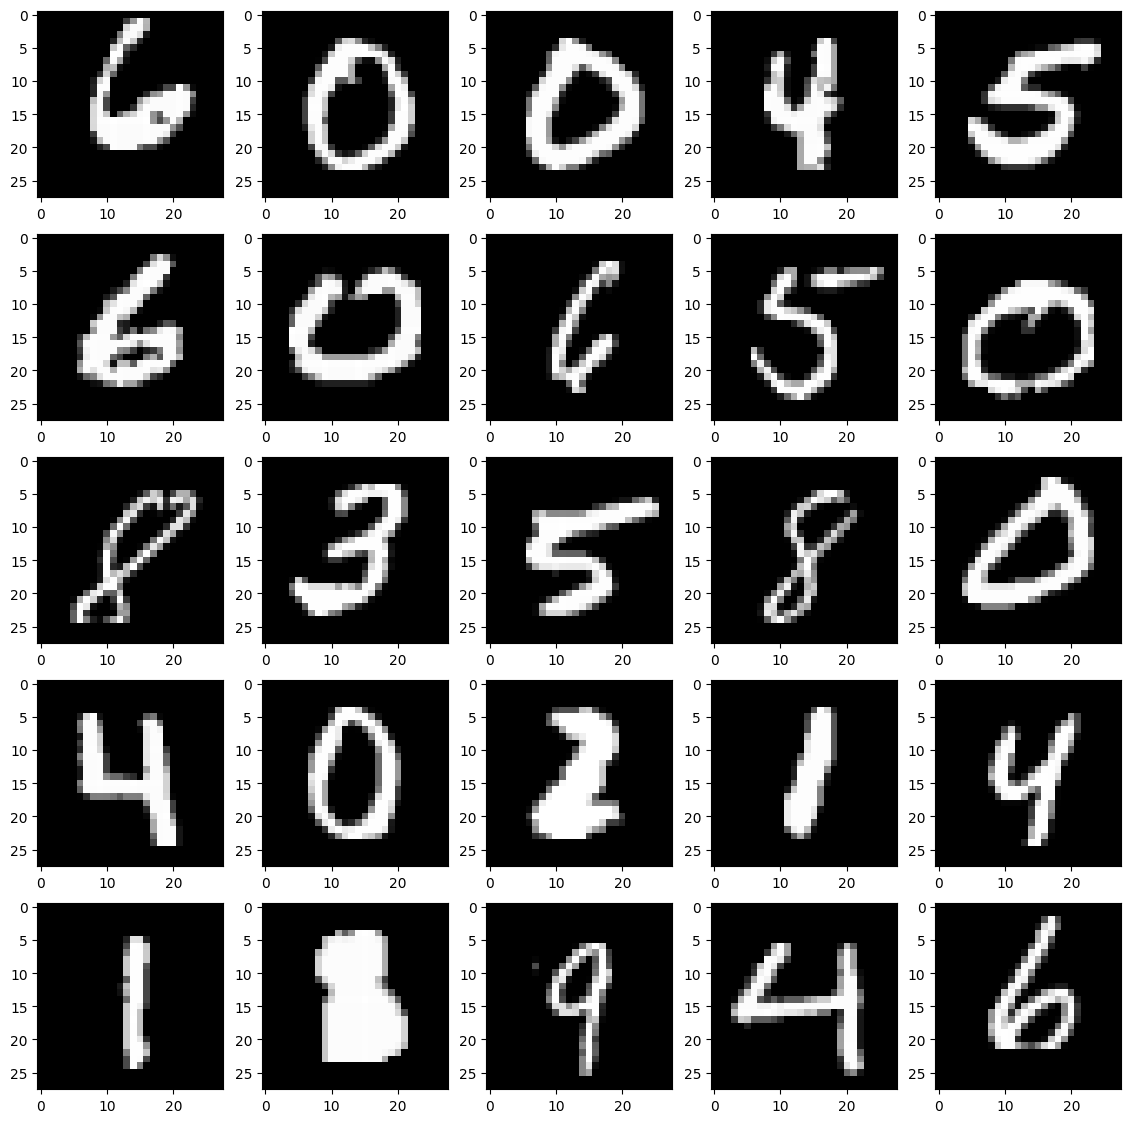

In [25]:
plot_25_images(real_image_chunks[0][:25])

In [26]:
fake_image_chunks = [create_fake_training_chunk(200) for _ in range(1)]

7/7 [==============================] - 0s 4ms/step


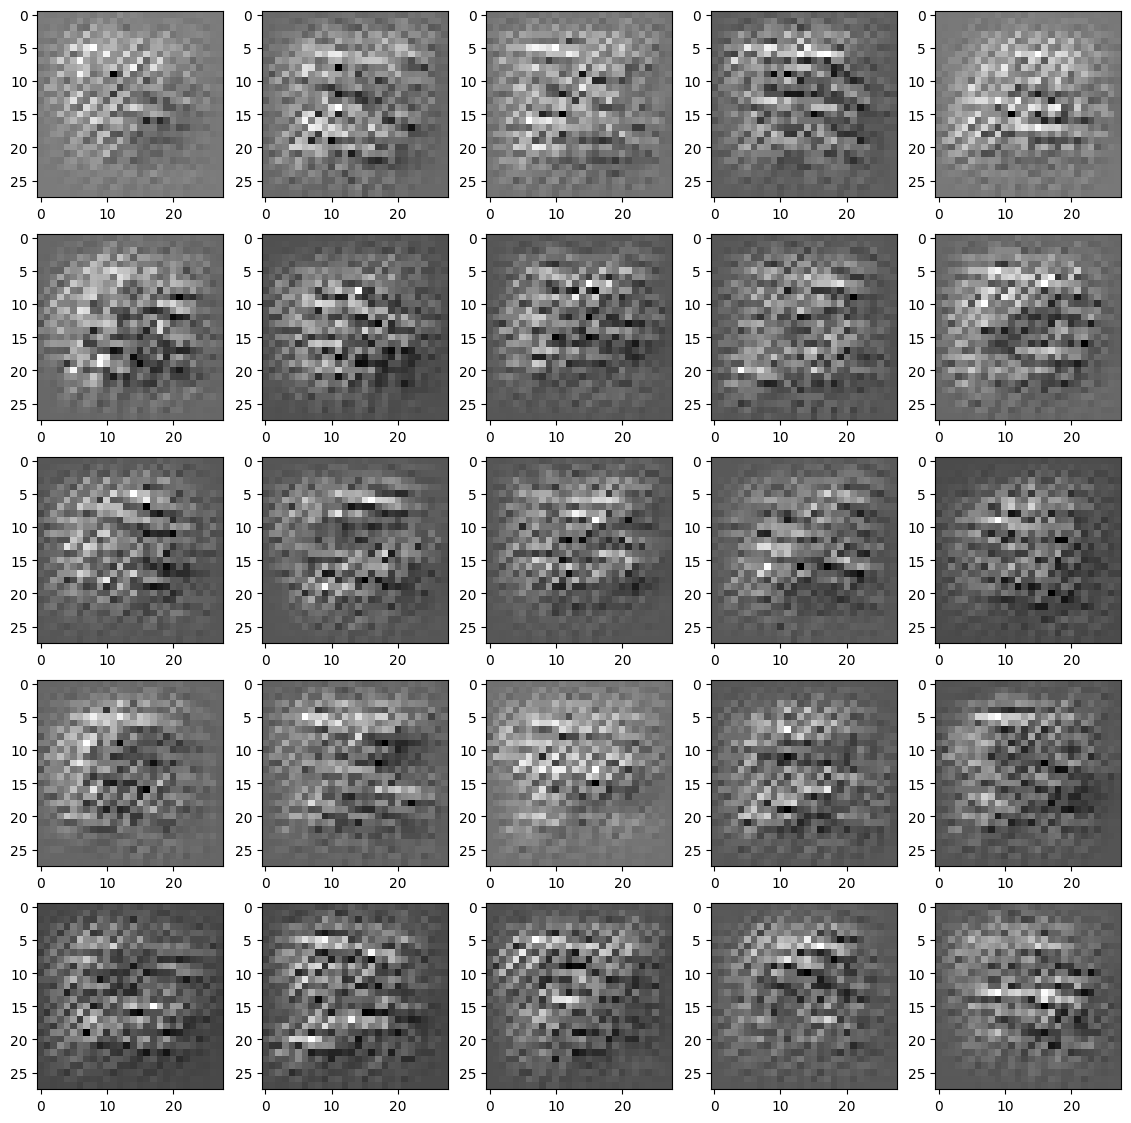

In [27]:
plot_25_images(fake_image_chunks[0][:25])

In [28]:
expected_output_fake = np.full((200,), 0.0)
expected_output_fake

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
expected_output_real = np.full((200,), 1.0)
expected_output_real

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [52]:
for real_chunk, fake_chunk in zip(real_image_chunks, fake_image_chunks):
    model_discriminator.fit(
        real_chunk, 
        expected_output_real,
        batch_size=25
    )
    model_discriminator.fit(
        fake_chunk, 
        expected_output_fake,
        batch_size=25
    )

8/8 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000


In [31]:
chunk_size = num_batches_before_alternating * real_batch_size
model_discriminator.trainable = True

for epoch in range(epochs):
    # plot_images_from_generator()
    # train both models in together training on a few batches each before alternating
    # get real data items for training in chunks
    for chunk_real_images, chunk_real_labels in generate_real_training_chunks(chunk_size):
        # train discriminator
        chunk_real_images = chunk_real_images.reshape(chunk_size, 28, 28)
        model_discriminator.fit(
            chunk_real_images,
            np.full((chunk_size,), 1.0),
            epochs=1,
            batch_size=real_batch_size,
        )
        
        fake_images = create_fake_training_chunk(chunk_size)
        fake_images = fake_images.reshape(chunk_size, 28, 28)
        model_discriminator.fit(
            fake_images,
            np.full((chunk_size,), 0.0),
            epochs=1,
            batch_size=real_batch_size,
        )

        
        # # train generator
        # model_discriminator.trainable = False
        
        # GAN_combined_model.fit(
        #     create_chunk_of_generator_inputs(chunk_size*2),
        #     np.full((chunk_size*2,), 1),
        #     epochs=1,
        #     batch_size=real_batch_size
        # )

        # model_discriminator.trainable = True


In [32]:
# plot_images_from_generator()

In [53]:
for real_images, real_labels in generate_real_training_chunks(20):
    print(model_discriminator.predict(real_images))
    break

fake_images = create_fake_training_chunk(20)
print(model_discriminator.predict(fake_images))

1/1 [==============================] - 0s 32ms/step
[[1.        ]
 [1.        ]
 [1.        ]
 [0.9999979 ]
 [0.99999994]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [1.        ]
 [0.99999326]
 [0.9999987 ]
 [0.9999971 ]
 [0.9999981 ]
 [1.        ]
 [0.9999953 ]
 [0.9941695 ]
 [0.9999999 ]
 [1.        ]
 [0.9999986 ]]
1/1 [==============================] - 0s 24ms/step
[[0.59446704]
 [0.59553564]
 [0.595296  ]
 [0.59486157]
 [0.5956697 ]
 [0.59501034]
 [0.59615445]
 [0.5956536 ]
 [0.59497845]
 [0.59497285]
 [0.594987  ]
 [0.5955171 ]
 [0.5948326 ]
 [0.59497017]
 [0.5952114 ]
 [0.59564143]
 [0.59470206]
 [0.5949213 ]
 [0.5946787 ]
 [0.5943377 ]]
